In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.backends.cudnn as cudnn
import torchvision
import torchvision.transforms as transforms
from tqdm import tqdm_notebook
import sys
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns                    transforms.Scale(config.image_size),

sns.set_style("darkgrid")
sys.path.append('/home/antixk/Anand/')
print(sys.path)

from NeuralBlocks.models.densenet import DenseNet

['/home/antixk/Anand/NeuralBlocks/notebooks', '/home/antixk/miniconda3/envs/main/lib/python37.zip', '/home/antixk/miniconda3/envs/main/lib/python3.7', '/home/antixk/miniconda3/envs/main/lib/python3.7/lib-dynload', '', '/home/antixk/miniconda3/envs/main/lib/python3.7/site-packages', '/home/antixk/miniconda3/envs/main/lib/python3.7/site-packages/IPython/extensions', '/home/antixk/.ipython', '/home/antixk/Anand/']


In [2]:
torch.manual_seed(2456)
cudnn.deterministic = True
cudnn.benchmark = False
np.random.seed(2456)

NUM_EPOCH = 200
BATCH_SIZE = 128
CHECKPOINT_INTERVAL = 100
LRS = [0.0001, 0.001, 0.1]
NORMS =[None,'BN', 'SN', 'MSN', 'MSNTReLU', 'WNTReLU']
DATA_PATH = "/home/antixk/Anand/NeuralBlocks/data_utils/datasets/CIFAR10/"
SAVE_PATH = "/home/antixk/Anand/NeuralBlocks/experiments/CIFAR10/"

os.makedirs(SAVE_PATH, exist_ok=True)

In [3]:
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

trainset = torchvision.datasets.CIFAR10(root=DATA_PATH, train=True, download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True, num_workers=8)

testset = torchvision.datasets.CIFAR10(root=DATA_PATH, train=False, download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

Files already downloaded and verified
Files already downloaded and verified


In [4]:
def train(epoch):
    net.train()
    train_loss = 0
    correct = 0
    total = 0
    for batch_idx, (inputs, targets) in enumerate(trainloader):
        inputs, targets = inputs.cuda(), targets.cuda()
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()
        
        train_loss_log.append(train_loss/(batch_idx+1))
        train_acc_log.append( 100.*correct/total)
        
        if(batch_idx%CHECKPOINT_INTERVAL==0):
             print("Train Epoch [{:3d}/{:3d}]Batch [{:3d}/{:3d}] Loss: {:.3f} Acc {:.3f}%".format(epoch, NUM_EPOCH,batch_idx, len(trainloader),
                train_loss/(batch_idx+1), 100.*correct/total))

def test(epoch):
    global best_acc
    net.eval()
    test_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(testloader):
            inputs, targets = inputs.cuda(), targets.cuda()
            outputs = net(inputs)
            loss = criterion(outputs, targets)

            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
            
            test_loss_log.append(test_loss/(batch_idx+1))
            test_acc_log.append( 100.*correct/total)
        
            if(batch_idx%CHECKPOINT_INTERVAL==0):
                print("Test Epoch [{:3d}/{:3d}]Batch [{:3d}/{:3d}] Loss: {:.3f} Acc {:.3f}%".format(epoch, NUM_EPOCH,batch_idx, len(testloader),
                test_loss/(batch_idx+1), 100.*correct/total))

    # Save checkpoint.
    acc = 100.*correct/total
    if acc > best_acc:
        print('Saving..')
        state = {
            'net': net.state_dict(),
            'acc': acc,
            'epoch': epoch,
        }
        if not os.path.isdir(SAVE_PATH+'checkpoint'):
            os.mkdir(SAVE_PATH+'checkpoint')
        torch.save(state, SAVE_PATH+'checkpoint/ckpt.pth')
        best_acc = acc

In [5]:
best_acc = 0 

for lr in tqdm_notebook(LRS):
    for norm in tqdm_notebook(NORMS):
        net = DenseNet(3, 10, norm=norm).cuda()
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(net.parameters(), lr=lr)

        train_loss_log =[]
        train_acc_log = []
        test_loss_log =[]
        test_acc_log =[]

        for epoch in tqdm_notebook(range(1)):
            train(epoch)
            test(epoch)

        np.save(SAVE_PATH+"DenseNet_Train_loss_{}_{}.npy".format(norm,lr), train_loss_log)  
        np.save(SAVE_PATH+"DenseNet_Test_loss_{}_{}.npy".format(norm,lr), test_loss_log)    
        np.save(SAVE_PATH+"DenseNet_Train_Acc_{}_{}.npy".format(norm,lr), train_acc_log)    
        np.save(SAVE_PATH+"DenseNet_Test_Acc_{}_{}.npy".format(norm,lr), test_acc_log)   
        del net

Train Epoch [  0/200]Batch [  0/391] Loss: 2.305 Acc 10.156%
Train Epoch [  0/200]Batch [100/391] Loss: 2.172 Acc 21.488%
Train Epoch [  0/200]Batch [200/391] Loss: 2.082 Acc 25.606%
Train Epoch [  0/200]Batch [300/391] Loss: 2.024 Acc 27.868%
Test Epoch [  0/200]Batch [  0/ 79] Loss: 1.747 Acc 43.750%
Saving..


Train Epoch [  0/200]Batch [  0/391] Loss: 2.362 Acc 8.594%
Train Epoch [  0/200]Batch [100/391] Loss: 2.107 Acc 24.033%
Train Epoch [  0/200]Batch [200/391] Loss: 2.013 Acc 28.141%
Train Epoch [  0/200]Batch [300/391] Loss: 1.959 Acc 30.560%
Test Epoch [  0/200]Batch [  0/ 79] Loss: 1.678 Acc 41.406%
Saving..


Train Epoch [  0/200]Batch [  0/391] Loss: 2.328 Acc 10.938%
Train Epoch [  0/200]Batch [100/391] Loss: 2.130 Acc 23.252%
Train Epoch [  0/200]Batch [200/391] Loss: 2.036 Acc 26.897%
Train Epoch [  0/200]Batch [300/391] Loss: 1.971 Acc 29.602%
Test Epoch [  0/200]Batch [  0/ 79] Loss: 1.678 Acc 46.875%


Train Epoch [  0/200]Batch [  0/391] Loss: 2.387 Acc 7.031%
Train Epoch [  0/200]Batch [100/391] Loss: 2.144 Acc 22.525%
Train Epoch [  0/200]Batch [200/391] Loss: 2.043 Acc 26.811%
Train Epoch [  0/200]Batch [300/391] Loss: 1.975 Acc 29.392%
Test Epoch [  0/200]Batch [  0/ 79] Loss: 1.696 Acc 48.438%


Train Epoch [  0/200]Batch [  0/391] Loss: 2.377 Acc 6.250%
Train Epoch [  0/200]Batch [100/391] Loss: 2.143 Acc 21.310%
Train Epoch [  0/200]Batch [200/391] Loss: 2.044 Acc 26.193%
Train Epoch [  0/200]Batch [300/391] Loss: 1.984 Acc 28.813%
Test Epoch [  0/200]Batch [  0/ 79] Loss: 1.667 Acc 43.750%


Train Epoch [  0/200]Batch [  0/391] Loss: 2.318 Acc 8.594%
Train Epoch [  0/200]Batch [100/391] Loss: 1.908 Acc 31.405%
Train Epoch [  0/200]Batch [200/391] Loss: 1.790 Acc 35.724%
Train Epoch [  0/200]Batch [300/391] Loss: 1.719 Acc 38.408%
Test Epoch [  0/200]Batch [  0/ 79] Loss: 1.348 Acc 49.219%
Saving..


Train Epoch [  0/200]Batch [  0/391] Loss: 2.331 Acc 9.375%
Train Epoch [  0/200]Batch [100/391] Loss: 1.925 Acc 30.801%
Train Epoch [  0/200]Batch [200/391] Loss: 1.797 Acc 35.728%
Train Epoch [  0/200]Batch [300/391] Loss: 1.727 Acc 38.276%
Test Epoch [  0/200]Batch [  0/ 79] Loss: 1.412 Acc 50.000%


Train Epoch [  0/200]Batch [  0/391] Loss: 2.372 Acc 10.938%
Train Epoch [  0/200]Batch [100/391] Loss: 1.913 Acc 30.894%
Train Epoch [  0/200]Batch [200/391] Loss: 1.785 Acc 35.560%
Train Epoch [  0/200]Batch [300/391] Loss: 1.717 Acc 38.388%
Test Epoch [  0/200]Batch [  0/ 79] Loss: 1.394 Acc 56.250%


Train Epoch [  0/200]Batch [  0/391] Loss: 2.420 Acc 7.031%
Train Epoch [  0/200]Batch [100/391] Loss: 1.903 Acc 31.822%
Train Epoch [  0/200]Batch [200/391] Loss: 1.791 Acc 35.728%
Train Epoch [  0/200]Batch [300/391] Loss: 1.719 Acc 38.385%
Test Epoch [  0/200]Batch [  0/ 79] Loss: 1.442 Acc 53.125%
Saving..


Train Epoch [  0/200]Batch [  0/391] Loss: 2.428 Acc 8.594%
Train Epoch [  0/200]Batch [100/391] Loss: 1.909 Acc 29.989%
Train Epoch [  0/200]Batch [200/391] Loss: 1.789 Acc 35.036%
Train Epoch [  0/200]Batch [300/391] Loss: 1.717 Acc 38.118%
Test Epoch [  0/200]Batch [  0/ 79] Loss: 1.466 Acc 49.219%


Train Epoch [  0/200]Batch [  0/391] Loss: 2.319 Acc 10.156%
Train Epoch [  0/200]Batch [100/391] Loss: 141.033 Acc 16.553%
Train Epoch [  0/200]Batch [200/391] Loss: 101.312 Acc 17.996%
Train Epoch [  0/200]Batch [300/391] Loss: 79.231 Acc 19.876%
Test Epoch [  0/200]Batch [  0/ 79] Loss: 5.328 Acc 34.375%


Train Epoch [  0/200]Batch [  0/391] Loss: 2.335 Acc 10.156%
Train Epoch [  0/200]Batch [100/391] Loss: 5.138 Acc 9.568%
Train Epoch [  0/200]Batch [200/391] Loss: 3.729 Acc 9.768%
Train Epoch [  0/200]Batch [300/391] Loss: 3.257 Acc 9.827%
Test Epoch [  0/200]Batch [  0/ 79] Loss: 2.332 Acc 7.812%


Train Epoch [  0/200]Batch [  0/391] Loss: 2.330 Acc 12.500%
Train Epoch [  0/200]Batch [100/391] Loss: 10.791 Acc 20.823%
Train Epoch [  0/200]Batch [200/391] Loss: 6.369 Acc 26.411%
Train Epoch [  0/200]Batch [300/391] Loss: 4.834 Acc 30.137%
Test Epoch [  0/200]Batch [  0/ 79] Loss: 1.422 Acc 47.656%


Train Epoch [  0/200]Batch [  0/391] Loss: 2.368 Acc 7.031%
Train Epoch [  0/200]Batch [100/391] Loss: 5.015 Acc 10.574%
Train Epoch [  0/200]Batch [200/391] Loss: 3.656 Acc 11.556%
Train Epoch [  0/200]Batch [300/391] Loss: 3.141 Acc 14.693%
Test Epoch [  0/200]Batch [  0/ 79] Loss: 1.997 Acc 28.906%


Train Epoch [  0/200]Batch [  0/391] Loss: 2.372 Acc 10.938%
Train Epoch [  0/200]Batch [100/391] Loss: 8.886 Acc 21.566%
Train Epoch [  0/200]Batch [200/391] Loss: 5.375 Acc 27.826%
Train Epoch [  0/200]Batch [300/391] Loss: 4.165 Acc 31.260%
Test Epoch [  0/200]Batch [  0/ 79] Loss: 1.488 Acc 45.312%



0
0
0
0
0


/home/antixk/miniconda3/envs/main/lib/python3.7/site-packages/ipykernel_launcher.py:11: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  # This is added back by InteractiveShellApp.init_path()
/home/antixk/miniconda3/envs/main/lib/python3.7/site-packages/ipykernel_launcher.py:19: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/home/antixk/miniconda3/envs/main/lib/python3.7/site-packages/ipykernel_launcher.py:27: MatplotlibDeprecationW

4
4
4
4
4


/home/antixk/miniconda3/envs/main/lib/python3.7/site-packages/ipykernel_launcher.py:11: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  # This is added back by InteractiveShellApp.init_path()
/home/antixk/miniconda3/envs/main/lib/python3.7/site-packages/ipykernel_launcher.py:19: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/home/antixk/miniconda3/envs/main/lib/python3.7/site-packages/ipykernel_launcher.py:27: MatplotlibDeprecationW

8


/home/antixk/miniconda3/envs/main/lib/python3.7/site-packages/ipykernel_launcher.py:11: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  # This is added back by InteractiveShellApp.init_path()


8
8
8
8



/home/antixk/miniconda3/envs/main/lib/python3.7/site-packages/ipykernel_launcher.py:19: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/home/antixk/miniconda3/envs/main/lib/python3.7/site-packages/ipykernel_launcher.py:27: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/home/antixk/miniconda3/envs/main/lib/python3.7/site-packages/ipykernel_launcher.py:35: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previ

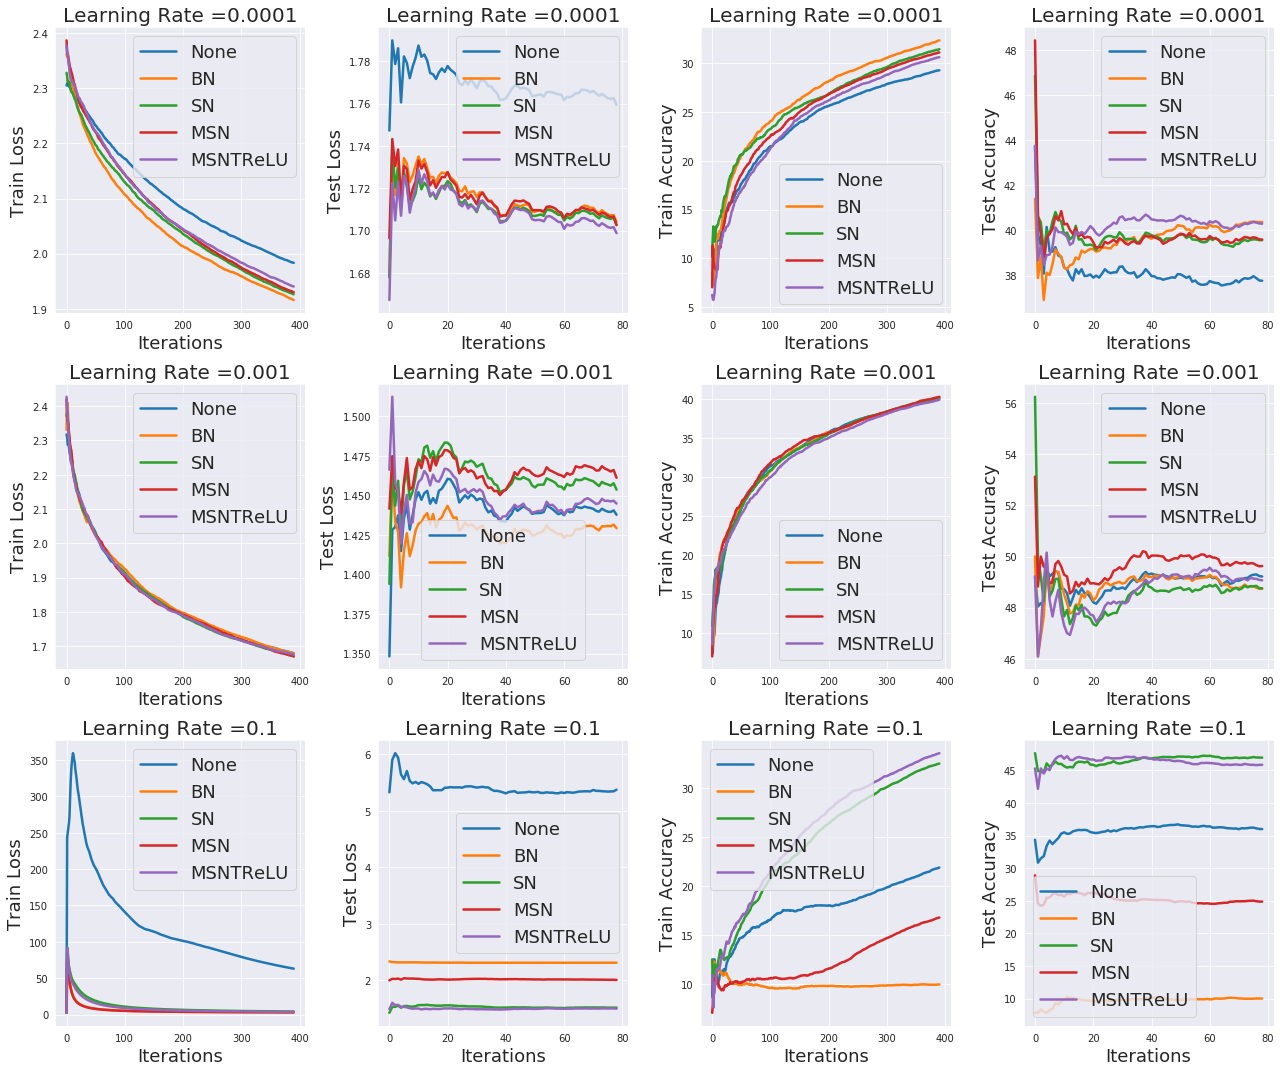

In [7]:
k = 0
plt.figure(figsize=(18, 15))
for i, lr in enumerate(tqdm_notebook(LRS)):    
    for j, norm in enumerate(tqdm_notebook([None,'BN', 'SN', 'MSN'])):
        print(k)
        train_loss_log = np.load(SAVE_PATH+"DenseNet_Train_loss_{}_{}.npy".format(norm,lr) )  
        test_loss_log = np.load(SAVE_PATH+"DenseNet_Test_loss_{}_{}.npy".format(norm,lr))    
        train_acc_log = np.load(SAVE_PATH+"DenseNet_Train_Acc_{}_{}.npy".format(norm,lr))    
        test_acc_log= np.load(SAVE_PATH+"DenseNet_Test_Acc_{}_{}.npy".format(norm,lr))   
        
        ax = plt.subplot(3,4,k+1)
        plt.plot(train_loss_log, lw=2.5, label=str(norm))
        plt.xlabel('Iterations', fontsize=18)
        plt.ylabel('Train Loss', fontsize=18)     
        plt.legend(fontsize=18)
        plt.grid(True)
        plt.title("Learning Rate ={}".format(lr), fontsize=20);

        ax = plt.subplot(3,4,k+2)
        plt.plot(test_loss_log, lw=2.5, label=str(norm))
        plt.xlabel('Iterations', fontsize=18)
        plt.ylabel('Test Loss', fontsize=18) 
        plt.legend(fontsize=18)
        plt.grid(True)
        plt.title("Learning Rate ={}".format(lr), fontsize=20);

        ax = plt.subplot(3,4,k+3)
        plt.plot(train_acc_log, lw=2.5, label=str(norm))
        plt.xlabel('Iterations', fontsize=18)
        plt.ylabel('Train Accuracy', fontsize=18) 
        plt.legend(fontsize=18)
        plt.grid(True)
        plt.title("Learning Rate ={}".format(lr), fontsize=20);
                
        ax = plt.subplot(3,4,k+4)
        plt.plot(test_acc_log, lw=2.5, label=str(norm))
        plt.xlabel('Iterations', fontsize=18)
        plt.ylabel('Test Accuracy', fontsize=18)        
        plt.legend(fontsize=18)
        plt.grid(True)
        plt.title("Learning Rate ={}".format(lr), fontsize=20);
    k+= 4
plt.tight_layout()
plt.savefig(SAVE_PATH+'Act_Norm_Results.pdf', dpi=400)

In [ ]:
k = 0
plt.figure(figsize=(18, 15))
for i, lr in enumerate(tqdm_notebook(LRS)):    
    for j, norm in enumerate(tqdm_notebook(['WN', 'SN', 'MSN'])):
        print(k)
        train_loss_log = np.load(SAVE_PATH+"DenseNet_Train_loss_{}_{}.npy".format(norm,lr) )  
        test_loss_log = np.load(SAVE_PATH+"DenseNet_Test_loss_{}_{}.npy".format(norm,lr))    
        train_acc_log = np.load(SAVE_PATH+"DenseNet_Train_Acc_{}_{}.npy".format(norm,lr))    
        test_acc_log= np.load(SAVE_PATH+"DenseNet_Test_Acc_{}_{}.npy".format(norm,lr))   
        
        ax = plt.subplot(3,4,k+1)
        plt.plot(train_loss_log, lw=2.5, label=str(norm))
        plt.xlabel('Iterations', fontsize=18)
        plt.ylabel('Train Loss', fontsize=18)     
        plt.legend(fontsize=18)
        plt.grid(True)
        plt.title("Learning Rate ={}".format(lr), fontsize=20);

        ax = plt.subplot(3,4,k+2)
        plt.plot(test_loss_log, lw=2.5, label=str(norm))
        plt.xlabel('Iterations', fontsize=18)
        plt.ylabel('Test Loss', fontsize=18) 
        plt.legend(fontsize=18)
        plt.grid(True)
        plt.title("Learning Rate ={}".format(lr), fontsize=20);

        ax = plt.subplot(3,4,k+3)
        plt.plot(train_acc_log, lw=2.5, label=str(norm))
        plt.xlabel('Iterations', fontsize=18)
        plt.ylabel('Train Accuracy', fontsize=18) 
        plt.legend(fontsize=18)
        plt.grid(True)
        plt.title("Learning Rate ={}".format(lr), fontsize=20);
                
        ax = plt.subplot(3,4,k+4)
        plt.plot(test_acc_log, lw=2.5, label=str(norm))
        plt.xlabel('Iterations', fontsize=18)
        plt.ylabel('Test Accuracy', fontsize=18)        
        plt.legend(fontsize=18)
        plt.grid(True)
        plt.title("Learning Rate ={}".format(lr), fontsize=20);
    k+= 4
plt.tight_layout()
plt.savefig(SAVE_PATH+'Weight_reparam_Results.pdf', dpi=400)

In [ ]:
k = 0
plt.figure(figsize=(18, 15))
for i, lr in enumerate(tqdm_notebook(LRS)):    
    for j, norm in enumerate(tqdm_notebook(['MSNTReLU', 'WNTReLU'])):
        print(k)
        train_loss_log = np.load(SAVE_PATH+"DenseNet_Train_loss_{}_{}.npy".format(norm,lr) )  
        test_loss_log = np.load(SAVE_PATH+"DenseNet_Test_loss_{}_{}.npy".format(norm,lr))    
        train_acc_log = np.load(SAVE_PATH+"DenseNet_Train_Acc_{}_{}.npy".format(norm,lr))    
        test_acc_log= np.load(SAVE_PATH+"DenseNet_Test_Acc_{}_{}.npy".format(norm,lr))   
        
        ax = plt.subplot(3,4,k+1)
        plt.plot(train_loss_log, lw=2.5, label=str(norm))
        plt.xlabel('Iterations', fontsize=18)
        plt.ylabel('Train Loss', fontsize=18)     
        plt.legend(fontsize=18)
        plt.grid(True)
        plt.title("Learning Rate ={}".format(lr), fontsize=20);

        ax = plt.subplot(3,4,k+2)
        plt.plot(test_loss_log, lw=2.5, label=str(norm))
        plt.xlabel('Iterations', fontsize=18)
        plt.ylabel('Test Loss', fontsize=18) 
        plt.legend(fontsize=18)
        plt.grid(True)
        plt.title("Learning Rate ={}".format(lr), fontsize=20);

        ax = plt.subplot(3,4,k+3)
        plt.plot(train_acc_log, lw=2.5, label=str(norm))
        plt.xlabel('Iterations', fontsize=18)
        plt.ylabel('Train Accuracy', fontsize=18) 
        plt.legend(fontsize=18)
        plt.grid(True)
        plt.title("Learning Rate ={}".format(lr), fontsize=20);
                
        ax = plt.subplot(3,4,k+4)
        plt.plot(test_acc_log, lw=2.5, label=str(norm))
        plt.xlabel('Iterations', fontsize=18)
        plt.ylabel('Test Accuracy', fontsize=18)        
        plt.legend(fontsize=18)
        plt.grid(True)
        plt.title("Learning Rate ={}".format(lr), fontsize=20);
    k+= 4
plt.tight_layout()
plt.savefig(SAVE_PATH+'Weight_reparam_act_Results.pdf', dpi=400)